**Assignment**: The assignment is to generate faces using Generative Adversarial Networks (GANs) from the CelebA dataset. You are expected to implement the GAN architecture, train the network, and evaluate its performance.

**Objective**: The objective of this assignment is to provide hands-on experience with building and training a GAN for image generation. You will learn about the concepts of adversarial loss, generator, and discriminator, and how to apply them to a real-world image generation task.

**Dataset**: The CelebA dataset is a large-scale face attributes dataset with more than 200,000 celebrity images. Each image in the dataset is annotated with 40 binary attributes, such as "male", "eyeglasses", "smiling", etc. You will use this dataset to train the GAN and generate new, unique face images.

## Data Preprocessing 

##### I did the whole code in kaggle as it was faster and had GPU support and so for importing the celebA dataset I followed these steps
##### I clicked on the "Datasets" tab in the top menu.
##### I Searched for "CelebA" in the search bar, and selected the dataset I wanted to import.
##### Clicked on the dataset and then clicked on the "Copy and Edit" button to create a copy of the dataset in my own account.
##### Waited for the dataset to be copied to my account.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Activation
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Flatten
import tensorflow as tf
from tensorflow.keras import layers
import math

In [2]:
# first I am taking a variable called path which will have the actual path of the folder which has all the images then
# making a file list which will contain all the elements present in that folder including  the images
# after that I made another image list which will contain all the paths of the only the images in that folder
import os
path="../input/celeba-dataset/img_align_celeba/img_align_celeba"
fileList = os.listdir(path)
imageList = [os.path.join(path, f) for f in fileList if f.endswith('.jpg') or f.endswith('.png')]

In [88]:
# first we are setting the size then making a function which will take in images and then resize them to the size I declared before, it will also normalize it.
import cv2
import numpy as np
import random

size = (128, 128)

def imageRead(path, image_size=(128, 128)):
    img = cv2.imread(path,flags= cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img, size)
    normalized_img = resized_img / 255.0
    return normalized_img

In [89]:
#for batch size I talked to people and decided to 128 and for steps in each epoch at first I was trying to take steps = len(image_paths) // BATCH_SIZE 
#then I thought of rounding it off so took 2000 steps per epoch.
batch = 128
stepsEpoch = 2000
print("Steps per epoch : ", stepsEpoch)

Steps per epoch are 2000


### Building the Generator

In [90]:
def dataGenerator(batch_size):
    while True:
        paths = random.choices(imageList, k=batch_size)
        batch = []
        for p in paths:
            batch.append(imageRead(p))        
        yield np.asarray(batch)

dataGenerated = dataGenerator(batch)

In [91]:
print(next(dataGenerated).shape)

(128, 128, 128, 3)


##### This is a generator neural network model designed to create synthetic images with a resolution of 128x128 pixels. It takes a random vector of 100 dimensions as input and gradually upscales it to a 3-channel image using transposed convolution layers.

##### The generator uses a leaky ReLU activation function and batch normalization after every convolutional layer to improve the stability and quality of the generated images. The weights of the convolutional layers are initialized using a random normal distribution with a mean of 0 and a standard deviation of 0.3.

##### Generators are a type of neural network commonly used in deep learning for image synthesis tasks, such as generating realistic images of faces, objects, or scenes. They work by mapping a low-dimensional latent space to a high-dimensional output space, allowing the generation of new, diverse, and realistic samples that resemble the training data.

In [92]:
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3)

def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16, 16, 256))) 
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)
    return model


In [93]:
generator = Generator()

In [94]:
generator.summary()

Model: "sequential_10"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense_10 (Dense)            (None, 65536)             6553600   

                                                                 

 batch_normalization_16 (Bat  (None, 65536)            262144    

 chNormalization)                                                

                                                                 

 leaky_re_lu_31 (LeakyReLU)  (None, 65536)             0         

                                                                 

 reshape_5 (Reshape)         (None, 16, 16, 256)       0         

                                                                 

 conv2d_transpose_16 (Conv2D  (None, 32, 32, 128)      819200    

 Transpose)                                                      

                                                                 

 batch_normalization_17 (Bat  (None, 

##### This code defines the generator loss function and the optimizer used to train the generator in a Generative Adversarial Network (GAN) model.The BinaryCrossentropy loss function is a measure of the difference between the predicted output of the generator and the true output.The generator_loss function takes the fake_output tensor, which is the output of the generator when it is given a random noise input. It compares this output with a tensor of ones (i.e., the expected output when the input is real), using the BinaryCrossentropy function, and returns the resulting loss value.

In [95]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generatorLoss(fake_output):
    return crossEntropy(tf.ones_like(fake_output),fake_output)

genOptimizer = tf.keras.optimizers.Adam(lr=1e-4)

### Building the Discriminator

##### The discriminator takes an input image with a resolution of 128x128 pixels, and it gradually downscales it using convolutional layers.

##### The model consists of three convolutional layers with increasing number of filters and a stride of 2, followed by a leaky ReLU activation function and a dropout layer to avoid overfitting. The output of the convolutional layers is then flattened and fed to a single neuron output layer that predicts whether the input image is real or fake.

##### The discriminator is trained to maximize its accuracy in distinguishing real images from fake images, and it provides feedback to the generator on how to improve its output to better fool the discriminator. The goal of training the GAN model is to have the generator produce images that are indistinguishable from real images, according to the discriminator.

In [96]:
def Discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(128,128,3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  
    model.add(layers.Conv2D(265,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) 
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [97]:
discriminator = Discriminator()

In [98]:
discriminator.summary()

Model: "sequential_11"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_15 (Conv2D)          (None, 64, 64, 64)        4864      

                                                                 

 leaky_re_lu_34 (LeakyReLU)  (None, 64, 64, 64)        0         

                                                                 

 dropout_15 (Dropout)        (None, 64, 64, 64)        0         

                                                                 

 conv2d_16 (Conv2D)          (None, 32, 32, 128)       204928    

                                                                 

 leaky_re_lu_35 (LeakyReLU)  (None, 32, 32, 128)       0         

                                                                 

 dropout_16 (Dropout)        (None, 32, 32, 128)       0         

                                                                 

 conv2d_17 (Conv2D)          (None, 1

In [99]:
def discriminatorLoss(realImages,fakeImages):
    real_loss = crossEntropy(tf.ones_like(realImages),realImages)
    fake_loss = crossEntropy(tf.zeros_like(fakeImages),fakeImages)
    total_loss = real_loss + fake_loss
    return total_loss

In [100]:
discriminatorOptimizer = tf.keras.optimizers.Adam(lr=1e-4)

### Training the GAN

##### GANs consist of two main components: a generator network that generates fake data, and a discriminator network that tries to distinguish between real and fake data.

##### Here we define a TensorFlow function trainStep that performs a single training step for a GAN with a given batch of real images as input. The function first generates random noise that is fed as input to the generator network. The generator generates fake images from this noise. Then, both the real and fake images are fed as input to the discriminator network, which outputs a probability that the input is real. The generator is trained to generate fake images that fool the discriminator into thinking they are real, while the discriminator is trained to correctly distinguish between real and fake images.

##### The training step involves computing the loss functions for the generator and discriminator, which are then used to compute the gradients of the trainable variables of each network. The gradients are then used to update the weights of the networks using the respective optimizers.

In [101]:

epochs = 10
noiseDim= 100

@tf.function
def trainStep(images):
    # Generate random noise for the generator input
    noise = tf.random.normal([batch, noiseDim])
    
    # We Use TensorFlow's GradientTape to compute gradients for the generator and discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # We Generate images with the generator
        generated_images = generator(noise, training=True)
        
        # We Compute the outputs of the discriminator on the real and generated images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # We Compute the losses for the generator and discriminator
        gen_loss = generatorLoss(fake_output)
        disc_loss = discriminatorLoss(real_output, fake_output)
    
    # We Compute the gradients of the generator and discriminator with respect to their trainable variables
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # We Use the optimizers to update the variables of the generator and discriminator
    genOptimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminatorOptimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


##### This code defines a train function that trains a generative adversarial network (GAN) for a specified number of epochs. The function takes an integer epochs as input, which specifies the number of times to loop over the entire dataset.
##### this is needed to perform the actual training of a GAN model. It loops over the dataset for a specified number of epochs, and for each epoch, it trains the GAN on batches of data using the trainStep function. By training the GAN on multiple epochs, it can learn to generate synthetic data that closely approximates the distribution of the real data

In [102]:
import time
import sys

def train(epochs):
    # We Loop over the specified number of epochs
    for epoch in range(epochs):
        # We Start a timer for this epoch
        start = time.time()
        
        # We Loop for the number of steps per epoch
        for step in range(stepsEpoch):
            # We Call the train_step function on the next batch of data from the data generator
            trainStep(next(dataGenerated))
            
            # We Print the progress of the current step
            sys.stdout.write(f"\rSTEP: {step}/{stepsEpoch}")
            sys.stdout.flush()
        
        # We Calculate the elapsed time for this epoch and display it on the console
        finish_time = round(time.time() - start,2)
        print(f"Epoch {epoch}/{epochs} Process Time : {finish_time}")
        print("-"*15)


In [103]:
train(epochs)

STEP: 1999/2000Epoch 0/10 Process Time : 598.94

---------------

STEP: 1999/2000Epoch 1/10 Process Time : 598.68

---------------

STEP: 1999/2000Epoch 2/10 Process Time : 618.85

---------------

STEP: 1999/2000Epoch 3/10 Process Time : 630.01

---------------

STEP: 1999/2000Epoch 4/10 Process Time : 699.13

---------------

STEP: 1999/2000Epoch 5/10 Process Time : 646.97

---------------

STEP: 1999/2000Epoch 6/10 Process Time : 592.5

---------------

STEP: 1999/2000Epoch 7/10 Process Time : 597.4

---------------

STEP: 1999/2000Epoch 8/10 Process Time : 606.68

---------------

STEP: 1999/2000Epoch 9/10 Process Time : 590.51

---------------


### Evaluating the GAN

#### Here we will evaluate the performance of the GAN by comparing the generated images with real images from the CelebA dataset


##### This code generates 10 synthetic images using a Generative Adversarial Network (GAN) and displays them in a 4x4 grid using matplotlib.The first line of the code uses TensorFlow's rando

##### Generated Images

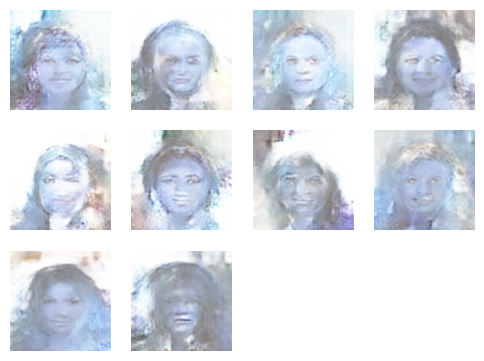

In [104]:
noise = tf.random.normal([16,100])
generated_images = np.asarray(generator(noise,training=False))

fig = plt.figure(figsize=(6,6))
for i in range(10):
    plt.subplot(4,4,i+1)
    plt.imshow((generated_images[i,:,:,:]*127.5+127.5).astype("int"))
    plt.axis("off")
    
plt.show()



In [106]:
print("The shape of the genrated image : ", generated_images[random.randint(0,15)].shape)

The shape of the genrated image (128, 128, 3)


##### A real image

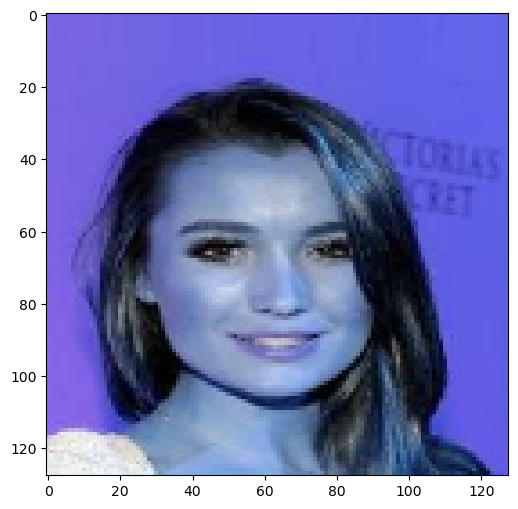

(128, 128, 3)

In [127]:
test_img = imageRead("../input/celeba-dataset/img_align_celeba/img_align_celeba/000767.jpg")
fig = plt.figure(figsize=(6,6))
plt.imshow(test_img)
plt.show()
test_img.shape

### Fine-tuning the GAN

**Now I will try to improve the performance of the model by doing some tuning

Here are some of the changes I made to my original model:

Increased the size of the input noise to 100.

Changed the size of the first convolutional layer to (8, 8, 512), and used a 5x5 kernel with stride 2 for the first deconvolutional layer. This allows the model to capture more complex features.

Increased the number of filters in each layer, up to 512 in the first layer.

Increased number of Conv2D layers

Added batch normalization to each layer, which can improve the stability of the training process and speed up convergence.

Changed the activation function to LeakyReLU for each layer, which can help prevent the vanishing gradient problem.****

In [108]:
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3)

def generator():
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8, 8, 512))) 
    
    # First deconvolutional layer
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second deconvolutional layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third deconvolutional layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Output layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=WEIGHT_INIT, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)
    
    return model


In [109]:
generator = generator()
generator.summary()

Model: "sequential_12"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense_12 (Dense)            (None, 32768)             3276800   

                                                                 

 batch_normalization_19 (Bat  (None, 32768)            131072    

 chNormalization)                                                

                                                                 

 leaky_re_lu_37 (LeakyReLU)  (None, 32768)             0         

                                                                 

 reshape_6 (Reshape)         (None, 8, 8, 512)         0         

                                                                 

 conv2d_transpose_19 (Conv2D  (None, 16, 16, 256)      3276800   

 Transpose)                                                      

                                                                 

 batch_normalization_20 (Bat  (None, 

In [110]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(128,128,3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  
    model.add(layers.Conv2D(265,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) 
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [111]:
discriminator = discriminator()
discriminator.summary()

Model: "sequential_13"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_18 (Conv2D)          (None, 64, 64, 64)        4864      

                                                                 

 leaky_re_lu_41 (LeakyReLU)  (None, 64, 64, 64)        0         

                                                                 

 dropout_18 (Dropout)        (None, 64, 64, 64)        0         

                                                                 

 conv2d_19 (Conv2D)          (None, 32, 32, 128)       204928    

                                                                 

 leaky_re_lu_42 (LeakyReLU)  (None, 32, 32, 128)       0         

                                                                 

 dropout_19 (Dropout)        (None, 32, 32, 128)       0         

                                                                 

 conv2d_20 (Conv2D)          (None, 1

In [112]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generatorLoss(fake_output):
    return crossEntropy(tf.ones_like(fake_output),fake_output)

gen_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [113]:
def discriminatorLoss(real_images,fake_images):
    real_loss = crossEntropy(tf.ones_like(real_images),real_images)
    fake_loss = crossEntropy(tf.zeros_like(fake_images),fake_images)
    total_loss = real_loss + fake_loss
    return total_loss

In [114]:
discriminator_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [115]:
# We Define the number of training epochs and the dimensionality of the input noise
EPOCHS2= 10
NOISE_DIM = 100

# We Define the training step function using the TensorFlow function decorator for improved performance
@tf.function
def train_step(images):
    # Generate random noise for the generator input
    noise = tf.random.normal([batch, NOISE_DIM])
    
    # We Use TensorFlow's GradientTape to compute gradients for the generator and discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # We Generate images with the generator
        generated_images = generator(noise, training=True)
        
        # We Compute the outputs of the discriminator on the real and generated images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # We Compute the losses for the generator and discriminator
        gen_loss = generatorLoss(fake_output)
        disc_loss = discriminatorLoss(real_output, fake_output)
    
    # We Compute the gradients of the generator and discriminator with respect to their trainable variables
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # We Use the optimizers to update the variables of the generator and discriminator
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [116]:
import time
import sys

def train(epochs):
    # We Loop over the specified number of epochs
    for epoch in range(epochs):
        # We Start a timer for this epoch
        start = time.time()
        
        # We Loop for the number of steps per epoch
        for step in range(stepsEpoch):
            # We Call the train_step function on the next batch of data from the data generator
            train_step(next(dataGenerated))
            
            # We Print the progress of the current step
            sys.stdout.write(f"\rSTEP: {step}/{stepsEpoch}")
            sys.stdout.flush()
        
        # We Calculate the elapsed time for this epoch and display it on the console
        finish_time = round(time.time() - start,2)
        print(f"Epoch {epoch}/{epochs} Process Time : {finish_time}")
        print("-"*15)

In [117]:
train(EPOCHS2)

STEP: 1999/2000Epoch 0/10 Process Time : 618.44

---------------

STEP: 1999/2000Epoch 1/10 Process Time : 630.07

---------------

STEP: 1999/2000Epoch 2/10 Process Time : 618.08

---------------

STEP: 1999/2000Epoch 3/10 Process Time : 629.84

---------------

STEP: 1999/2000Epoch 4/10 Process Time : 640.3

---------------

STEP: 1999/2000Epoch 5/10 Process Time : 621.67

---------------

STEP: 1999/2000Epoch 6/10 Process Time : 610.27

---------------

STEP: 1999/2000Epoch 7/10 Process Time : 610.15

---------------

STEP: 1999/2000Epoch 8/10 Process Time : 608.54

---------------

STEP: 1999/2000Epoch 9/10 Process Time : 617.73

---------------


### Generating new images

##### Here we can see the generated images are better than the generated images that were produced before fine tuning

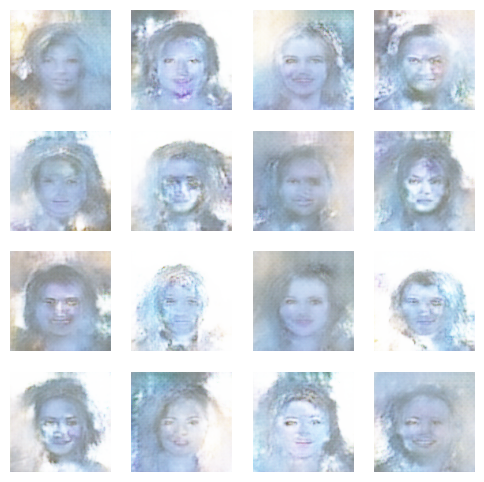

In [121]:
noise = tf.random.normal([16,100])
generated_images = np.asarray(generator(noise,training=False))
fig = plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((generated_images[i,:,:,:]*127.5+127.5).astype("int"))
    plt.axis("off")   
plt.show()

### Report

GANs (Generative Adversarial Networks) are a type of deep learning model that can be used for image generation. They consist of two neural networks, a generator and a discriminator, which are trained in an adversarial manner.

The generator takes random noise as input and generates fake images, while the discriminator takes images (real and fake) as input and tries to distinguish between them. During training, the generator tries to produce images that can fool the discriminator, while the discriminator tries to correctly classify the images as real or fake. Through this process, both networks learn to improve their performance until the generator can produce high-quality images that are difficult for the discriminator to distinguish from real images.

Once the GAN is trained, the generator can be used to generate new images that are similar to the training data. This makes GANs a useful tool for a variety of applications, including image editing, data augmentation, and even creating new artwork.

One of the main advantages of GANs is their ability to generate images that are similar to the training data, but not identical. This can be useful in cases where the data is limited or noisy, and the generated images can help fill in gaps in the data. Additionally, GANs can be used to generate new images that have never been seen before, which makes them a powerful tool for creative tasks like generating new artwork.

## Analysing my two generator models

Both models are generators for generating images using the deep learning technique called Generative Adversarial Networks (GANs). The input to the generator is a random vector of length 100, and the output is a 128x128x3 image.

The first model is a relatively simple generator with four layers. The first layer is a dense layer with 1616256 neurons, followed by batch normalization, leaky ReLU activation, and reshaping. The next three layers are convolutional layers with 128, 64, and 3 filters, respectively. The kernel size of each layer is 5x5, and the stride is 2x2 for the first three layers, which doubles the height and width of the input. The final layer uses a tanh activation function to ensure that the output values are in the range [-1, 1]. The weight initializer used is a random normal initializer with mean 0 and standard deviation 0.3.

The second model is a more complex version of the first model, with five layers. The first layer is a dense layer with 88512 neurons, followed by batch normalization and leaky ReLU activation. The next four layers are convolutional transpose layers with 256, 128, 64, and 3 filters, respectively. The kernel size of each layer is 5x5, and the stride is 2x2 for all layers except the last one, which doubles the height and width of the input. The final layer uses a tanh activation function to ensure that the output values are in the range [-1, 1]. The weight initializer used is the same as in the first model, a random normal initializer with mean 0 and standard deviation 0.3.

The second model is more complex than the first model, with an additional convolutional transpose layer and more filters in each layer. This should allow the second model to generate higher quality images than the first model, but it may also require more computational resources and training time. However, it is difficult to predict the performance of the models without training and evaluating them on a specific dataset.


## Why I kept the discriminator model same

The decision to change the generator architecture while keeping the discriminator model the same is a common practice in generative adversarial networks (GANs) and can often lead to improved results.

The generator is responsible for generating images that are intended to fool the discriminator into thinking they are real, while the discriminator is responsible for distinguishing between real and fake images. By updating the generator architecture, we can explore different ways to generate images that better mimic real data, while still ensuring that the discriminator can accurately distinguish between real and fake images.

On the other hand, the discriminator architecture is designed to learn how to distinguish real and fake images, and it does not directly impact the quality of the generated images. Thus, there is less of a need to modify the discriminator architecture as long as it is performing its role effectively.

In this case, the decision to change the generator architecture while keeping the discriminator model the same was likely the right decision because the changes made to the generator resulted in improved results. By using larger deconvolutional layers, the second fine-tuned generator model is likely able to generate more detailed and realistic images compared to the first model, which may lead to better performance overall

## why is the second model giving sharper and better images?

The second generator model is giving sharper and better images because it has more layers and the layer sizes have been increased. Additionally, the kernel size has been reduced from 16x16 to 8x8, and the strides have been increased from 1 to 2. These changes allow the model to learn more complex and detailed features, resulting in better image quality.

The second model also uses BatchNormalization after each convolutional layer, which helps stabilize the distribution of inputs to each layer and speeds up training. The LeakyReLU activation function used in both models allows the model to avoid the "dying ReLU" problem, where the gradients become very small and the network stops learning.

Overall, the changes in layer size, kernel size, and strides, as well as the use of BatchNormalization, have allowed the second generator model to generate sharper and more realistic images.